In [1]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import StackingRegressor
from sklearn import metrics
from sklearn.impute import SimpleImputer


import pandas as pd
import numpy as np

# Read the dataset
df_wqi = pd.read_csv("water_dataX.csv", encoding= 'unicode_escape')
# Selecting 1900 samples, because samples having indices greater than 1900 are not correct
df_wqi = df_wqi.iloc[0:1900, :]
df_air = pd.read_csv('AQI.csv', encoding='unicode_escape').dropna()



# Water quality features
features_water = list(df_wqi.columns)[3:11]
X_water = df_wqi[features_water]
y_water = pd.read_csv('data_cluster.csv')['WQI clf']

In [2]:
# Converting object data type to numeric
def convert_to_numeric(df_wqi):
    num_col = df_wqi.shape[1]
    # Start from index 3
    for index in range(3, num_col):
        col_name = df_wqi.iloc[:, index].name
        df_wqi[col_name] = pd.to_numeric(df_wqi[col_name], errors="coerce")
    return df_wqi

df_wqi = convert_to_numeric(df_wqi)
df_wqi.dtypes

STATION CODE                         object
LOCATIONS                            object
STATE                                object
Temp                                float64
D.O. (mg/l)                         float64
PH                                  float64
CONDUCTIVITY (mhos/cm)              float64
B.O.D. (mg/l)                       float64
NITRATENAN N+ NITRITENANN (mg/l)    float64
FECAL COLIFORM (MPN/100ml)          float64
TOTAL COLIFORM (MPN/100ml)Mean      float64
year                                  int64
dtype: object

In [3]:
# Replacing string NAN values with actual NAN value (np.nan)
def convert_to_nan(df):
    n_col = df.shape[1]
    for index in range(n_col):
        df.iloc[:, index]  = df.iloc[:, index].replace("NAN", np.nan)
    return df

df_wqi = convert_to_nan(df_wqi)

In [4]:
# Replacing NULL values with median of column
# Selecting numeric data
df_num = df_wqi.select_dtypes(exclude="object")
df_num_col = df_num.columns
imputer = SimpleImputer(strategy="median")

df_num = imputer.fit_transform(df_num)
df_num = pd.DataFrame(df_num, columns=df_num_col)

# Filling Categorical missing values
df_cat = df_wqi.select_dtypes(include="object")
df_cat.isnull().sum()

# Here we can fill these values by obeserving other attributes
# Example - 
pd.set_option('mode.chained_assignment', None)
df_cat_copy = df_cat.copy()

df_cat_copy[df_cat_copy["STATION CODE"] == "1330"]
# Station Code with value 1330 will have Location - TAMBIRAPARANI which belongs in STATE - TAMIL NADU
# I can replace all the NAN occurences in STATE with TAMILNADU
df_cat_copy["STATE"][df_cat_copy["STATION CODE"] == "1330"] = df_cat_copy["STATE"][df_cat_copy["STATION CODE"] == "1330"].fillna("TAMILNADU")

df_cat_copy[df_cat_copy["STATION CODE"] == "1330"]

# The NULL values in LOCATION attribute are in STATE attribute (ex - above dataframe)
# So, I will fill the NULL values in LOCATION attribute with the corresponding STATE value
# And, the state value will be replaced by the function "fill_state" defined below this cell

def fill_locations(df_cat):
    location_null = df_cat[df_cat["LOCATIONS"].isnull()]
    location_null_indices = location_null.index
    for index in location_null_indices:
        state_value = location_null["STATE"][index]
        location_null["LOCATIONS"][index] = state_value
        location_null["STATE"][index] = np.nan
    df_cat[df_cat["LOCATIONS"].isnull()] = location_null
    return

fill_locations(df_cat_copy)
df_cat_copy[df_cat_copy["STATION CODE"] == "1330"]

df_cat_copy[df_cat_copy["LOCATIONS"] == "TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU"]

# Now I can fill NULL values of Station code with corresponding LOCATION value(ex - above dataframe)
# I will match the corresponding LOCATION value with other same LOCATION value and insert the value of station code

def fill_code(df_cat):
    station_null = df_cat[df_cat["STATION CODE"].isnull()]
    station_null_indices = station_null.index
    for index in station_null_indices:
        stat_code = np.nan
        location_index = station_null["LOCATIONS"][index]
        code_at_location = df_cat["STATION CODE"][df_cat["LOCATIONS"] == location_index]
        for index_code in code_at_location.index:
            if (code_at_location[index_code] != np.nan):
                stat_code = code_at_location[index_code]
                break
        station_null["STATION CODE"][index] = stat_code
    df_cat[df_cat["STATION CODE"].isnull()] = station_null
    return

fill_code(df_cat_copy)
df_cat_copy[df_cat_copy["LOCATIONS"] == "TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU"]

# Filling all state NAN values which have corresponding station code value
def fill_state(df_cat):
    station_code = df_cat["STATION CODE"].unique()
    for index in range(station_code.shape[0]):
        if (station_code[index] != np.nan):
            df_state = df_cat["STATE"][df_cat["STATION CODE"] == station_code[index]] 
            state_values = df_cat["STATE"][df_cat["STATION CODE"] == station_code[index]]
            state = np.nan
            for index_state in range(state_values.shape[0]):
                if (state_values.iloc[index_state] != np.nan):
                    state = state_values.iloc[index_state]
                    break
            df_state_fill = df_state.fillna(state) 
            df_cat["STATE"][df_cat["STATION CODE"] == station_code[index]] = df_state_fill
    return
fill_state(df_cat_copy)
df_cat_copy[df_cat_copy["STATION CODE"] == "1330"]

df_cat_copy.isnull().sum()

df_cat_copy[df_cat_copy["STATE"].isnull()]

# The first location KABBANI AT MUTHANKARA is in STATE Kerela
df_cat_copy["STATE"][1106] = "KERALA"
df_cat_copy["STATE"][1107] = "KERALA"
df_cat_copy["STATE"][1650] = "CHANDIGARH"
df_cat_copy["STATE"][1651] = "CHANDIGARH"
df_cat_copy["STATE"][1652] = "CHANDIGARH"
df_cat_copy["STATE"][1770] = "CHANDIGARH"
df_cat_copy["STATE"][1771] = "CHANDIGARH"
df_cat_copy["STATE"][1772] = "CHANDIGARH"
df_cat_copy["STATE"][1784] = "DAMAN & DIU"
df_cat_copy["STATE"][1785] = "DAMAN & DIU"
df_cat_copy["STATION CODE"][1784] = "0000" # I am setting this according to myself
df_cat_copy["STATION CODE"][1785] = "0000"

df_cat = df_cat_copy
df_cat.isnull().sum()

df_num.isnull().sum()

df_final = pd.concat([df_cat, df_num], axis=1)
df_final.isnull().sum()

# These are the samples which don't contain any attribute
# The filled attributes are median of corresponding columns
# So it is best to remove them
df_null = df_final[(df_final["STATION CODE"].isnull()) & (df_final["LOCATIONS"].isnull()) & (df_final["STATE"].isnull())]
df_null_indices = df_null.index
df_final.drop(df_null_indices, axis=0, inplace=True)
df_null

df_final.isnull().sum()

df_num_final = df_final.select_dtypes(exclude="object")


In [5]:
X_water.describe()
X_water.dtypes

Temp                                object
D.O. (mg/l)                         object
PH                                  object
CONDUCTIVITY (mhos/cm)              object
B.O.D. (mg/l)                       object
NITRATENAN N+ NITRITENANN (mg/l)    object
FECAL COLIFORM (MPN/100ml)          object
TOTAL COLIFORM (MPN/100ml)Mean      object
dtype: object

In [6]:
from scipy.stats import zscore
# Here, almost all kde plots are Gaussian Like 
# Using Z-Score Normalization to detect outliers

df_num_final_norm = zscore(df_num_final, axis=0)


def indices_of_greater_than_3(df_norm):
    indices_arr = []
    n_col = df_norm.shape[1]
    for index in range(n_col):
        col_index = df_norm.iloc[: ,index]
        greater_than_3 = df_norm[col_index > 3]
        greater_than_3_index = greater_than_3.index
        indices_arr.extend(greater_than_3_index)
    return indices_arr

indices_arr = indices_of_greater_than_3(df_num_final_norm)
print("Number of outliers using Z-Score method-",len(indices_arr))
df_final.iloc[indices_arr, :]

Number of outliers using Z-Score method- 125


,STATION CODE,LOCATIONS,STATE,Temp,D.O. (mg/l),PH,CONDUCTIVITY (mhos/cm),B.O.D. (mg/l),NITRATENAN N+ NITRITENANN (mg/l),FECAL COLIFORM (MPN/100ml),TOTAL COLIFORM (MPN/100ml)Mean,year
741,2880,NAMBUL RIVER AT BISHNUPUR,MANIPUR,28.0,8.2,7.6,112.0,2.1,0.52,233.0,31.0,2012.0
745,2856,"THOUBAL RIVER AT YAIRIPOK, THOUBAL",MANIPUR,30.0,9.3,7.6,193.0,2.3,0.52,233.0,41.0,2012.0
37,2671,KUNDALIKA RIVER NEAR SALAV BRIDGE (SALINA ZONE...,MAHARASHTRA,25.3,5.3,7.7,24062.0,9.9,1.20,156.0,304.0,2014.0
88,2294,R KALLAI AT KALLAI BRIDGE,KERALA,26.3,3.7,7.7,32005.0,1.2,0.90,40000.0,60392.0,2014.0
108,2304,R MOGRAL AT MOGRAL BR.,KERALA,30.0,5.6,7.2,24360.0,2.1,0.30,92.0,447.0,2014.0
...,...,...,...,...,...,...,...,...,...,...,...,...
432,1023,"GHAGGAR AT MUBARAKPUR REST HOUSE (PATIALA), PU...",PUNJAB,23.3,5.5,7.2,636.0,9.7,4.00,1328.0,4975.0,2013.0
685,1023,GHAGGAR AT MUBARAKPUR REST HOUSE (PATIALA),PUNJAB,21.0,5.5,7.4,635.0,8.8,5.08,1400.0,5500.0,2012.0
172,3023,"VASISTA AT SALEM, D/S OF SAGO INDUSRIES EFFLUE...",TAMILNADU,24.3,0.9,7.6,2039.0,104.5,0.90,272521616.0,511090873.0,2014.0
432,1023,"GHAGGAR AT MUBARAKPUR REST HOUSE (PATIALA), PU...",PUNJAB,23.3,5.5,7.2,636.0,9.7,4.00,1328.0,4975.0,2013.0


In [7]:
df_final.drop(indices_arr, axis=0, inplace=True)
df_final.shape

(1785, 12)

In [8]:
# Calculating Water Quality Index of each sample
df_num_final = df_final.select_dtypes(exclude="object")
# Dropping year and Temp attribute because they are not used for computing WQI
df_num_final.drop(["year", "Temp"], axis=1, inplace=True)

# Weight Vector(wi)
wi = np.array([0.2213, 0.2604, 0.0022, 0.4426, 0.0492, 0.0221, 0.0022])

# Standard values of parameters(si)
si = np.array([10, 8.5, 1000, 5, 45, 100, 1000])

# Ideal values of paramters(vIdeal)
vIdeal = np.array([14.6, 7, 0, 0, 0, 0, 0])

def calc_wqi(sample): 
    wqi_sample = 0
    num_col = 7
    for index in range(num_col):
        v_index = sample[index] # Obeserved value of sample at index
        v_index_ideal = vIdeal[index] # Ideal value of obeserved value
        w_index = wi[index] # weight of corresponding parameter of obeserved value
        std_index = si[index] # Standard value recommended for obeserved value
        q_index = (v_index - v_index_ideal) / (std_index - v_index_ideal)
        q_index = q_index * 100 # Final qi value of obeserved value
        wqi_sample += q_index*w_index
    return wqi_sample

In [9]:
# Computing WQI for the whole dataset
def calc_wqi_for_df(df):
    wqi_arr = []
    for index in range(df.shape[0]):
        index_row = df.iloc[index, :]
        wqi_row = calc_wqi(index_row)
        wqi_arr.append(wqi_row)
    return wqi_arr

In [10]:
wqi_arr = calc_wqi_for_df(df_num_final)
# Converting oridnary array to numpy array
wqi_arr = np.array(wqi_arr)
wqi_arr = np.reshape(wqi_arr, (-1, 1))

# Resetting index values of the dataframes
wqi_arr_df = pd.DataFrame(wqi_arr, columns=["WQI"]).reset_index()
df_final = df_final.reset_index()

In [11]:
# Combining dataframe of WQI and dataframe of attributes 
df_wqi = pd.concat([df_final, pd.DataFrame(wqi_arr, columns=["WQI"])], axis=1)
df_wqi.drop("index", axis=1, inplace=True)
df_wqi.shape

(1785, 13)

In [12]:
# These are samples with negative WQI
df_wqi[(df_wqi["WQI"] < 0)]

,STATION CODE,LOCATIONS,STATE,Temp,D.O. (mg/l),PH,CONDUCTIVITY (mhos/cm),B.O.D. (mg/l),NITRATENAN N+ NITRITENANN (mg/l),FECAL COLIFORM (MPN/100ml),TOTAL COLIFORM (MPN/100ml)Mean,year,WQI
196,3375,LUKHA RIVER AT MYNDIHATI (TRIBUTARY OF LUNAR),MEGHALAYA,20.5,6.7,2.7,1350.0,3.3000,1.10,7.0,16.0,2014.0,-6.855044
231,2,"DAMANGANGA AT D/S OF MADHUBAN, DAMAN",DAMAN & DIU,27.0,6.7,0.0,208.0,1.8965,0.52,233.0,465.0,2013.0,-61.372099
234,1865,RIVER DHADAR AT KOTHADA,GUJARAT,27.0,6.7,0.0,506.0,1.8965,6.00,26.0,227.0,2013.0,-65.334452
446,3375,LUKHA RIVER,MEGHALAYA,21.3,6.8,2.7,1074.0,3.2000,2.33,4.0,11.0,2013.0,-8.214971
719,3375,LUKHA RIVER AT MYNDIHATI (TRIBUTARY OF LUNAR),MEGHALAYA,25.0,6.9,2.6,1072.0,3.2000,1.17,3.0,21.0,2012.0,-10.579224


In [13]:
# Removing the samples with negative WQI
df_neg_indices = df_wqi[(df_wqi["WQI"] < 0)].index
df_wqi.drop(df_neg_indices, axis=0, inplace=True)

In [14]:
df_wqi["WQI clf"] = df_wqi["WQI"].apply(lambda x: ('Excellent' if (x <= 25)
                                        else('Good' if (26<=x<=50)
                                        else('Satisfactory' if (51<=x<=75)
                                        else('Poor' if (76<=x<=100)
                                        else 'Severe')))))

In [15]:
features = list(df_wqi.columns)[3:11]
X_water = df_wqi[features]
df_wqi

,STATION CODE,LOCATIONS,STATE,Temp,D.O. (mg/l),PH,CONDUCTIVITY (mhos/cm),B.O.D. (mg/l),NITRATENAN N+ NITRITENANN (mg/l),FECAL COLIFORM (MPN/100ml),TOTAL COLIFORM (MPN/100ml)Mean,year,WQI,WQI clf
0,1393,"DAMANGANGA AT D/S OF MADHUBAN, DAMAN",DAMAN & DIU,30.6,6.7,7.50,203.0,1.8965,0.100,11.0,27.0,2014.0,63.778321,Satisfactory
1,1399,ZUARI AT D/S OF PT. WHERE KUMBARJRIA CANAL JOI...,GOA,29.8,5.7,7.20,189.0,2.0000,0.200,4953.0,8391.0,2014.0,175.363506,Severe
2,1475,ZUARI AT PANCHAWADI,GOA,29.5,6.3,6.90,179.0,1.7000,0.100,3243.0,5330.0,2014.0,126.135831,Severe
3,3181,RIVER ZUARI AT BORIM BRIDGE,GOA,29.7,5.8,6.90,64.0,3.8000,0.500,5382.0,8443.0,2014.0,195.105659,Severe
4,3182,RIVER ZUARI AT MARCAIM JETTY,GOA,29.5,5.8,7.30,83.0,1.9000,0.400,3428.0,5500.0,2014.0,141.393246,Severe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1780,1329,"TAMBIRAPARANI AT RAIL BDG. NR. AMBASAMUDAM, TA...",TAMILNADU,27.0,7.4,7.00,88.5,0.9770,0.186,27.0,105.0,2005.0,43.946271,Good
1781,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU,27.0,6.6,7.81,603.2,2.6750,0.263,40.0,191.0,2005.0,77.315135,Poor
1782,1450,"PALAR AT VANIYAMBADI WATER SUPPLY HEAD WORK, T...",TAMILNADU,28.0,6.6,7.49,571.5,2.0910,0.256,151.0,273.0,2005.0,69.053768,Satisfactory
1783,1403,"GUMTI AT U/S SOUTH TRIPURA,TRIPURA",TRIPURA,28.0,5.4,7.16,75.8,2.0920,0.520,404.0,513.0,2005.0,74.670773,Satisfactory


In [16]:
features = list(df_wqi.columns)[:]
data_cluster = df_wqi['WQI clf']
data_cluster.describe()

Y = data_cluster
y_water = Y

In [17]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_water)

X_water = X_scaled

X_water

array([[ 1.34919038,  0.21273941,  0.46679752, ..., -0.62596683,
        -0.27290525, -0.1794082 ],
       [ 1.10152283, -0.58184389, -0.04813777, ..., -0.56458042,
         0.32560606,  0.02855377],
       [ 1.0086475 , -0.10509391, -0.56307306, ..., -0.62596683,
         0.11851291, -0.04755474],
       ...,
       [ 0.54427084,  0.13328108,  0.44963301, ..., -0.53020403,
        -0.25595025, -0.17329167],
       [ 0.54427084, -0.82021888, -0.11679581, ..., -0.36814393,
        -0.22531016, -0.16732433],
       [ 1.16343972, -0.82021888,  0.24365889, ..., -0.55537246,
        -0.21901259, -0.16623031]])

In [18]:
# Average the WQI values based on STATE so there is only one value per STATE
df_wqi_avg = df_wqi.groupby("STATE").mean()
df_wqi_avg.reset_index(inplace=True)
df_wqi_avg = df_wqi_avg.drop("year", axis=1)
df_wqi_avg = df_wqi_avg.drop("Temp", axis=1)
df_wqi_avg_y = df_wqi_avg[['STATE', 'WQI']]
df_wqi_avg_X = df_wqi_avg.drop("WQI", axis=1)
#df_wqi_avg_X = df_wqi_avg_X.drop("STATE", axis=1)
df_wqi_avg_y['WQI clf'] = df_wqi_avg_y["WQI"].apply(lambda x: ('Excellent' if (x <= 25)
                                        else('Good' if (26<=x<=50)
                                        else('Satisfactory' if (51<=x<=75)
                                        else('Poor' if (76<=x<=100)
                                        else 'Severe')))))
df_wqi_avg_y = df_wqi_avg_y.drop("WQI", axis=1)
df_wqi_avg_y

/var/folders/72/z1rg7v4n0tqckznknymhcd9w0000gn/T/ipykernel_57878/2992157561.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_wqi_avg = df_wqi.groupby("STATE").mean()


,STATE,WQI clf
0,ANDHRA PRADESH,Satisfactory
1,CHANDIGARH,Severe
2,DAMAN & DIU,Poor
3,"DAMAN, DIU, DADRA NAGAR HAVELI",Severe
4,GOA,Poor
5,GUJARAT,Severe
6,HARYANA,Severe
7,HIMACHAL PRADESH,Severe
8,KARNATAKA,Satisfactory
9,KERALA,Satisfactory


In [19]:
'''
# Average the AQI values based on state so there is only one value per state
df_aqi_avg = df_air.groupby("state").mean()
df_aqi_avg.reset_index(inplace=True)
#df_aqi_avg.columns
df_aqi_avg_y = df_aqi_avg[['state', 'AQI']]
df_aqi_avg_y['AQI Bucket'] = df_aqi_avg['AQI'].apply(lambda x: ('Good' if (x <= 50)
                                        else('Satisfactory' if (51<=x<=100)
                                        else('Moderate' if (101<=x<=200)
                                        else('Poor' if (201<=x<=300)
                                        else('Very Poor' if (301<=x<=400)
                                        else 'Severe'))))))
df_aqi_avg_y = df_aqi_avg_y.drop("AQI", axis=1)
df_aqi_avg_X = df_aqi_avg.drop("AQI", axis=1)
df_aqi_avg_X = df_aqi_avg_X.drop("Unnamed: 0", axis=1)
df_aqi_avg_y
'''

'\n# Average the AQI values based on state so there is only one value per state\ndf_aqi_avg = df_air.groupby("state").mean()\ndf_aqi_avg.reset_index(inplace=True)\n#df_aqi_avg.columns\ndf_aqi_avg_y = df_aqi_avg[[\'state\', \'AQI\']]\ndf_aqi_avg_y[\'AQI Bucket\'] = df_aqi_avg[\'AQI\'].apply(lambda x: (\'Good\' if (x <= 50)\n                                        else(\'Satisfactory\' if (51<=x<=100)\n                                        else(\'Moderate\' if (101<=x<=200)\n                                        else(\'Poor\' if (201<=x<=300)\n                                        else(\'Very Poor\' if (301<=x<=400)\n                                        else \'Severe\'))))))\ndf_aqi_avg_y = df_aqi_avg_y.drop("AQI", axis=1)\ndf_aqi_avg_X = df_aqi_avg.drop("AQI", axis=1)\ndf_aqi_avg_X = df_aqi_avg_X.drop("Unnamed: 0", axis=1)\ndf_aqi_avg_y\n'

In [20]:
df_aqi_avg_y = df_air[['state', 'AQI']]
df_aqi_avg_y['AQI Bucket'] = df_air['AQI'].apply(lambda x: ('Good' if (x <= 50)
                                        else('Satisfactory' if (51<=x<=100)
                                        else('Moderate' if (101<=x<=200)
                                        else('Poor' if (201<=x<=300)
                                        else('Very Poor' if (301<=x<=400)
                                        else 'Severe'))))))
df_aqi_avg_y = df_aqi_avg_y.drop("AQI", axis=1)
#df_aqi_avg_y = df_aqi_avg_y.drop("state", axis=1)
df_aqi_avg_y

,state,AQI Bucket
0,Andhra Pradesh,Good
1,Andhra Pradesh,Good
2,Andhra Pradesh,Good
3,Andhra Pradesh,Good
4,Andhra Pradesh,Good
...,...,...
435737,West Bengal,Satisfactory
435738,West Bengal,Satisfactory
435739,andaman-and-nicobar-islands,Good
435740,Lakshadweep,Good


In [21]:

df_air

,Unnamed: 0,state,location,type,so2,no2,rspm,spm,pm2_5,SOi,Noi,Rpi,SPMi,AQI,AQI_Range
0,0,Andhra Pradesh,Hyderabad,"Residential, Rural and other Areas",4.8,17.4,0.0,0.0,0.0,6.000,21.750,0.0,0.0,21.750,Good
1,1,Andhra Pradesh,Hyderabad,Industrial Area,3.1,7.0,0.0,0.0,0.0,3.875,8.750,0.0,0.0,8.750,Good
2,2,Andhra Pradesh,Hyderabad,"Residential, Rural and other Areas",6.2,28.5,0.0,0.0,0.0,7.750,35.625,0.0,0.0,35.625,Good
3,3,Andhra Pradesh,Hyderabad,"Residential, Rural and other Areas",6.3,14.7,0.0,0.0,0.0,7.875,18.375,0.0,0.0,18.375,Good
4,4,Andhra Pradesh,Hyderabad,Industrial Area,4.7,7.5,0.0,0.0,0.0,5.875,9.375,0.0,0.0,9.375,Good
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
435737,435737,West Bengal,ULUBERIA,RIRUO,22.0,50.0,143.0,0.0,0.0,27.500,62.500,0.0,0.0,62.500,Moderate
435738,435738,West Bengal,ULUBERIA,RIRUO,20.0,46.0,171.0,0.0,0.0,25.000,57.500,0.0,0.0,57.500,Moderate
435739,435739,andaman-and-nicobar-islands,Guwahati,"Residential, Rural and other Areas",0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.0,0.000,Good
435740,435740,Lakshadweep,Guwahati,"Residential, Rural and other Areas",0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.0,0.000,Good


In [22]:
# capitalize the state column name in both dataframes
df_air['STATE'] = df_air['state'].str.upper()
df_aqi_avg_y['STATE'] = df_aqi_avg_y['state'].str.upper()
df_air = df_air.drop("state", axis=1)
df_aqi_avg_y = df_aqi_avg_y.drop("state", axis=1)
df_aqi_avg_y

,AQI Bucket,STATE
0,Good,ANDHRA PRADESH
1,Good,ANDHRA PRADESH
2,Good,ANDHRA PRADESH
3,Good,ANDHRA PRADESH
4,Good,ANDHRA PRADESH
...,...,...
435737,Satisfactory,WEST BENGAL
435738,Satisfactory,WEST BENGAL
435739,Good,ANDAMAN-AND-NICOBAR-ISLANDS
435740,Good,LAKSHADWEEP


In [23]:
# Combine the two dataframes based on state
df_avg = pd.merge(df_air, df_wqi_avg_X, on='STATE')
df_avg_y = pd.merge(df_aqi_avg_y, df_wqi_avg_y, on='STATE')
df_avg_y = df_avg_y.drop("STATE", axis=1)
df_avg = df_avg.drop("STATE", axis=1)
df_avg

,Unnamed: 0,location,type,so2,no2,rspm,spm,pm2_5,SOi,Noi,...,SPMi,AQI,AQI_Range,D.O. (mg/l),PH,CONDUCTIVITY (mhos/cm),B.O.D. (mg/l),NITRATENAN N+ NITRITENANN (mg/l),FECAL COLIFORM (MPN/100ml),TOTAL COLIFORM (MPN/100ml)Mean
0,0,Hyderabad,"Residential, Rural and other Areas",4.8,17.4,0.0,0.0,0.0,6.000,21.750,...,0.0,21.750,Good,6.271435,7.678391,415.947826,0.982826,1.530174,326.521739,3539.000000
1,1,Hyderabad,Industrial Area,3.1,7.0,0.0,0.0,0.0,3.875,8.750,...,0.0,8.750,Good,6.271435,7.678391,415.947826,0.982826,1.530174,326.521739,3539.000000
2,2,Hyderabad,"Residential, Rural and other Areas",6.2,28.5,0.0,0.0,0.0,7.750,35.625,...,0.0,35.625,Good,6.271435,7.678391,415.947826,0.982826,1.530174,326.521739,3539.000000
3,3,Hyderabad,"Residential, Rural and other Areas",6.3,14.7,0.0,0.0,0.0,7.875,18.375,...,0.0,18.375,Good,6.271435,7.678391,415.947826,0.982826,1.530174,326.521739,3539.000000
4,4,Hyderabad,Industrial Area,4.7,7.5,0.0,0.0,0.0,5.875,9.375,...,0.0,9.375,Good,6.271435,7.678391,415.947826,0.982826,1.530174,326.521739,3539.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
311984,364232,Trichy,"Residential, Rural and other Areas",0.0,0.0,104.0,0.0,0.0,0.000,0.000,...,0.0,0.000,Good,6.850000,7.600000,467.000000,1.500000,0.165000,485.500000,1242.500000
311985,364233,Trichy,"Residential, Rural and other Areas",14.0,24.0,132.0,0.0,0.0,17.500,30.000,...,0.0,30.000,Good,6.850000,7.600000,467.000000,1.500000,0.165000,485.500000,1242.500000
311986,364234,Trichy,"Residential, Rural and other Areas",15.0,25.0,147.0,0.0,0.0,18.750,31.250,...,0.0,31.250,Good,6.850000,7.600000,467.000000,1.500000,0.165000,485.500000,1242.500000
311987,364235,Trichy,"Residential, Rural and other Areas",15.0,24.0,138.0,0.0,0.0,18.750,30.000,...,0.0,30.000,Good,6.850000,7.600000,467.000000,1.500000,0.165000,485.500000,1242.500000


In [24]:
'''
Air List:
                                        
                                        lambda x: ('Good' if (x <= 50)
                                        else('Satisfactory' if (51<=x<=100)
                                        else('Moderate' if (101<=x<=200)
                                        else('Poor' if (201<=x<=300)
                                        else('Very Poor' if (301<=x<=400)
                                        else 'Severe'))))

Water List:
df_wqi_avg_y['WQI clf'] = df_wqi_avg_y["WQI"].apply(lambda x: ('Excellent' if (x <= 25)
                                        else('Good' if (26<=x<=50)
                                        else('Satisfactory' if (51<=x<=75)
                                        else('Poor' if (76<=x<=100)
                                        else 'Severe')))))
'''

'\nAir List:\n                                        \n                                        lambda x: (\'Good\' if (x <= 50)\n                                        else(\'Satisfactory\' if (51<=x<=100)\n                                        else(\'Moderate\' if (101<=x<=200)\n                                        else(\'Poor\' if (201<=x<=300)\n                                        else(\'Very Poor\' if (301<=x<=400)\n                                        else \'Severe\'))))\n\nWater List:\ndf_wqi_avg_y[\'WQI clf\'] = df_wqi_avg_y["WQI"].apply(lambda x: (\'Excellent\' if (x <= 25)\n                                        else(\'Good\' if (26<=x<=50)\n                                        else(\'Satisfactory\' if (51<=x<=75)\n                                        else(\'Poor\' if (76<=x<=100)\n                                        else \'Severe\')))))\n'

In [25]:
df_avg.drop('Noi', axis=1, inplace=True)
df_avg.drop('Rpi', axis=1, inplace=True)
df_avg.drop('SPMi', axis=1, inplace=True)
df_avg.drop('AQI', axis=1, inplace=True)
df_avg

,Unnamed: 0,location,type,so2,no2,rspm,spm,pm2_5,SOi,AQI_Range,D.O. (mg/l),PH,CONDUCTIVITY (mhos/cm),B.O.D. (mg/l),NITRATENAN N+ NITRITENANN (mg/l),FECAL COLIFORM (MPN/100ml),TOTAL COLIFORM (MPN/100ml)Mean
0,0,Hyderabad,"Residential, Rural and other Areas",4.8,17.4,0.0,0.0,0.0,6.000,Good,6.271435,7.678391,415.947826,0.982826,1.530174,326.521739,3539.000000
1,1,Hyderabad,Industrial Area,3.1,7.0,0.0,0.0,0.0,3.875,Good,6.271435,7.678391,415.947826,0.982826,1.530174,326.521739,3539.000000
2,2,Hyderabad,"Residential, Rural and other Areas",6.2,28.5,0.0,0.0,0.0,7.750,Good,6.271435,7.678391,415.947826,0.982826,1.530174,326.521739,3539.000000
3,3,Hyderabad,"Residential, Rural and other Areas",6.3,14.7,0.0,0.0,0.0,7.875,Good,6.271435,7.678391,415.947826,0.982826,1.530174,326.521739,3539.000000
4,4,Hyderabad,Industrial Area,4.7,7.5,0.0,0.0,0.0,5.875,Good,6.271435,7.678391,415.947826,0.982826,1.530174,326.521739,3539.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
311984,364232,Trichy,"Residential, Rural and other Areas",0.0,0.0,104.0,0.0,0.0,0.000,Good,6.850000,7.600000,467.000000,1.500000,0.165000,485.500000,1242.500000
311985,364233,Trichy,"Residential, Rural and other Areas",14.0,24.0,132.0,0.0,0.0,17.500,Good,6.850000,7.600000,467.000000,1.500000,0.165000,485.500000,1242.500000
311986,364234,Trichy,"Residential, Rural and other Areas",15.0,25.0,147.0,0.0,0.0,18.750,Good,6.850000,7.600000,467.000000,1.500000,0.165000,485.500000,1242.500000
311987,364235,Trichy,"Residential, Rural and other Areas",15.0,24.0,138.0,0.0,0.0,18.750,Good,6.850000,7.600000,467.000000,1.500000,0.165000,485.500000,1242.500000


In [26]:
# Create a new dataframe with one column that you will keep on adding values to
labeled_data = pd.DataFrame(columns=['EPI'])
for i in range(0, len(df_avg_y)):
    air_classification = df_avg_y['AQI Bucket'][i]
    water_classification = df_avg_y['WQI clf'][i]
    if(air_classification == water_classification):
        labeled_data.loc[i] = df_avg_y['AQI Bucket'][i]
    else:
        if air_classification == 'Good' and water_classification == 'Excellent':
            overall_classification = 'Excellent'
        elif air_classification == 'Good' and water_classification == 'Good':
            overall_classification = 'Good'
        elif air_classification == 'Good' and water_classification == 'Satisfactory':
            overall_classification = 'Good'
        elif air_classification == 'Good' and water_classification == 'Poor':
            overall_classification = 'Fair'
        elif air_classification == 'Good' and water_classification == 'Severe':
            overall_classification = 'Bad'
        elif air_classification == 'Satisfactory' and water_classification == 'Excellent':
            overall_classification = 'Good'
        elif air_classification == 'Satisfactory' and water_classification == 'Good':
            overall_classification = 'Good'
        elif air_classification == 'Satisfactory' and water_classification == 'Satisfactory':
            overall_classification = 'Satisfactory'
        elif air_classification == 'Satisfactory' and water_classification == 'Poor':
            overall_classification = 'Fair'
        elif air_classification == 'Satisfactory' and water_classification == 'Severe':
            overall_classification = 'Bad'
        elif air_classification == 'Moderate' and water_classification == 'Excellent':
            overall_classification = 'Good'
        elif air_classification == 'Moderate' and water_classification == 'Good':
            overall_classification = 'Good'
        elif air_classification == 'Moderate' and water_classification == 'Satisfactory':
            overall_classification = 'Fair'
        elif air_classification == 'Moderate' and water_classification == 'Poor':
            overall_classification = 'Fair'
        elif air_classification == 'Moderate' and water_classification == 'Severe':
            overall_classification = 'Bad'
        elif air_classification == 'Poor' and water_classification == 'Excellent':
            overall_classification = 'Fair'
        elif air_classification == 'Poor' and water_classification == 'Good':
            overall_classification = 'Poor'
        elif air_classification == 'Poor' and water_classification == 'Satisfactory':
            overall_classification = 'Bad'
        elif air_classification == 'Poor' and water_classification == 'Poor':
            overall_classification = 'Worse'
        elif air_classification == 'Poor' and water_classification == 'Severe':
            overall_classification = 'Worse'
        elif air_classification == 'Very Poor' and water_classification == 'Excellent':
            overall_classification = 'Poor'
        elif air_classification == 'Very Poor' and water_classification == 'Good':
            overall_classification = 'Poor'
        elif air_classification == 'Very Poor' and water_classification == 'Satisfactory':
            overall_classification = 'Poor'
        elif air_classification == 'Very Poor' and water_classification == 'Poor':
            overall_classification = 'Bad'
        elif air_classification == 'Very Poor' and water_classification == 'Severe':
            overall_classification = 'Worse'
        elif air_classification == 'Severe' and water_classification == 'Excellent':
            overall_classification = 'Bad'
        elif air_classification == 'Severe' and water_classification == 'Good':
            overall_classification = 'Bad'
        elif air_classification == 'Severe' and water_classification == 'Satisfactory':
            overall_classification = 'Worse'
        elif air_classification == 'Severe' and water_classification == 'Poor':
            overall_classification = 'Worse'
        elif air_classification == 'Severe' and water_classification == 'Severe':
            overall_classification = 'Worse'
        labeled_data.loc[i] = overall_classification


In [27]:
# chop the data down to only 1000 rows
#labeled_data = labeled_data[:30000]
#df_avg = df_avg[:30000]

In [28]:
df_avg

,Unnamed: 0,location,type,so2,no2,rspm,spm,pm2_5,SOi,AQI_Range,D.O. (mg/l),PH,CONDUCTIVITY (mhos/cm),B.O.D. (mg/l),NITRATENAN N+ NITRITENANN (mg/l),FECAL COLIFORM (MPN/100ml),TOTAL COLIFORM (MPN/100ml)Mean
0,0,Hyderabad,"Residential, Rural and other Areas",4.8,17.4,0.0,0.0,0.0,6.000,Good,6.271435,7.678391,415.947826,0.982826,1.530174,326.521739,3539.000000
1,1,Hyderabad,Industrial Area,3.1,7.0,0.0,0.0,0.0,3.875,Good,6.271435,7.678391,415.947826,0.982826,1.530174,326.521739,3539.000000
2,2,Hyderabad,"Residential, Rural and other Areas",6.2,28.5,0.0,0.0,0.0,7.750,Good,6.271435,7.678391,415.947826,0.982826,1.530174,326.521739,3539.000000
3,3,Hyderabad,"Residential, Rural and other Areas",6.3,14.7,0.0,0.0,0.0,7.875,Good,6.271435,7.678391,415.947826,0.982826,1.530174,326.521739,3539.000000
4,4,Hyderabad,Industrial Area,4.7,7.5,0.0,0.0,0.0,5.875,Good,6.271435,7.678391,415.947826,0.982826,1.530174,326.521739,3539.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
311984,364232,Trichy,"Residential, Rural and other Areas",0.0,0.0,104.0,0.0,0.0,0.000,Good,6.850000,7.600000,467.000000,1.500000,0.165000,485.500000,1242.500000
311985,364233,Trichy,"Residential, Rural and other Areas",14.0,24.0,132.0,0.0,0.0,17.500,Good,6.850000,7.600000,467.000000,1.500000,0.165000,485.500000,1242.500000
311986,364234,Trichy,"Residential, Rural and other Areas",15.0,25.0,147.0,0.0,0.0,18.750,Good,6.850000,7.600000,467.000000,1.500000,0.165000,485.500000,1242.500000
311987,364235,Trichy,"Residential, Rural and other Areas",15.0,24.0,138.0,0.0,0.0,18.750,Good,6.850000,7.600000,467.000000,1.500000,0.165000,485.500000,1242.500000


In [29]:
labeled_data['EPI'].unique()

array(['Good', 'Fair', 'Satisfactory', 'Bad', 'Poor', 'Worse', 'Severe'],
      dtype=object)

In [30]:
df_avg.drop('AQI_Range', axis=1, inplace=True)

In [40]:
df_output_for_website = df_avg.copy()
df_output_for_website

,so2,no2,rspm,spm,pm2_5,D.O. (mg/l),PH,CONDUCTIVITY (mhos/cm),B.O.D. (mg/l),NITRATENAN N+ NITRITENANN (mg/l),FECAL COLIFORM (MPN/100ml),TOTAL COLIFORM (MPN/100ml)Mean
0,4.8,17.4,0.0,0.0,0.0,6.271435,7.678391,415.947826,0.982826,1.530174,326.521739,3539.000000
1,3.1,7.0,0.0,0.0,0.0,6.271435,7.678391,415.947826,0.982826,1.530174,326.521739,3539.000000
2,6.2,28.5,0.0,0.0,0.0,6.271435,7.678391,415.947826,0.982826,1.530174,326.521739,3539.000000
3,6.3,14.7,0.0,0.0,0.0,6.271435,7.678391,415.947826,0.982826,1.530174,326.521739,3539.000000
4,4.7,7.5,0.0,0.0,0.0,6.271435,7.678391,415.947826,0.982826,1.530174,326.521739,3539.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
311984,0.0,0.0,104.0,0.0,0.0,6.850000,7.600000,467.000000,1.500000,0.165000,485.500000,1242.500000
311985,14.0,24.0,132.0,0.0,0.0,6.850000,7.600000,467.000000,1.500000,0.165000,485.500000,1242.500000
311986,15.0,25.0,147.0,0.0,0.0,6.850000,7.600000,467.000000,1.500000,0.165000,485.500000,1242.500000
311987,15.0,24.0,138.0,0.0,0.0,6.850000,7.600000,467.000000,1.500000,0.165000,485.500000,1242.500000


In [31]:
df_avg = df_avg.drop('Unnamed: 0', axis=1)
df_avg = df_avg.drop('location', axis=1)
df_avg = df_avg.drop('type', axis=1)
df_avg = df_avg.drop('SOi', axis=1)
df_avg

,so2,no2,rspm,spm,pm2_5,D.O. (mg/l),PH,CONDUCTIVITY (mhos/cm),B.O.D. (mg/l),NITRATENAN N+ NITRITENANN (mg/l),FECAL COLIFORM (MPN/100ml),TOTAL COLIFORM (MPN/100ml)Mean
0,4.8,17.4,0.0,0.0,0.0,6.271435,7.678391,415.947826,0.982826,1.530174,326.521739,3539.000000
1,3.1,7.0,0.0,0.0,0.0,6.271435,7.678391,415.947826,0.982826,1.530174,326.521739,3539.000000
2,6.2,28.5,0.0,0.0,0.0,6.271435,7.678391,415.947826,0.982826,1.530174,326.521739,3539.000000
3,6.3,14.7,0.0,0.0,0.0,6.271435,7.678391,415.947826,0.982826,1.530174,326.521739,3539.000000
4,4.7,7.5,0.0,0.0,0.0,6.271435,7.678391,415.947826,0.982826,1.530174,326.521739,3539.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
311984,0.0,0.0,104.0,0.0,0.0,6.850000,7.600000,467.000000,1.500000,0.165000,485.500000,1242.500000
311985,14.0,24.0,132.0,0.0,0.0,6.850000,7.600000,467.000000,1.500000,0.165000,485.500000,1242.500000
311986,15.0,25.0,147.0,0.0,0.0,6.850000,7.600000,467.000000,1.500000,0.165000,485.500000,1242.500000
311987,15.0,24.0,138.0,0.0,0.0,6.850000,7.600000,467.000000,1.500000,0.165000,485.500000,1242.500000


In [32]:
df_avg

,so2,no2,rspm,spm,pm2_5,D.O. (mg/l),PH,CONDUCTIVITY (mhos/cm),B.O.D. (mg/l),NITRATENAN N+ NITRITENANN (mg/l),FECAL COLIFORM (MPN/100ml),TOTAL COLIFORM (MPN/100ml)Mean
0,4.8,17.4,0.0,0.0,0.0,6.271435,7.678391,415.947826,0.982826,1.530174,326.521739,3539.000000
1,3.1,7.0,0.0,0.0,0.0,6.271435,7.678391,415.947826,0.982826,1.530174,326.521739,3539.000000
2,6.2,28.5,0.0,0.0,0.0,6.271435,7.678391,415.947826,0.982826,1.530174,326.521739,3539.000000
3,6.3,14.7,0.0,0.0,0.0,6.271435,7.678391,415.947826,0.982826,1.530174,326.521739,3539.000000
4,4.7,7.5,0.0,0.0,0.0,6.271435,7.678391,415.947826,0.982826,1.530174,326.521739,3539.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
311984,0.0,0.0,104.0,0.0,0.0,6.850000,7.600000,467.000000,1.500000,0.165000,485.500000,1242.500000
311985,14.0,24.0,132.0,0.0,0.0,6.850000,7.600000,467.000000,1.500000,0.165000,485.500000,1242.500000
311986,15.0,25.0,147.0,0.0,0.0,6.850000,7.600000,467.000000,1.500000,0.165000,485.500000,1242.500000
311987,15.0,24.0,138.0,0.0,0.0,6.850000,7.600000,467.000000,1.500000,0.165000,485.500000,1242.500000


In [33]:
# Go through the labeled data and change the word worse to severe
for i in range(0, len(labeled_data)):
    if labeled_data['EPI'][i] == 'Worse':
        labeled_data['EPI'][i] = 'Severe'

In [34]:
# Write a stacking ensemble classifier which is going to learn the data to the labels
# Create the necessary imports
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Write the train-test split
X_train, X_test, y_train, y_test = train_test_split(df_avg, labeled_data, test_size=0.2, random_state=42)

# Write the stacking ensemble classification algorithm
estimators = [('rf', RandomForestClassifier(n_estimators=10, random_state=42)),
                ('svr', SVC(random_state=42))]
clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

# Fit the model
clf.fit(X_train, y_train)

# Predict the values
y_pred = clf.predict(X_test)

# Print the accuracy score
print("Accuracy Score: ", accuracy_score(y_test, y_pred))

/Users/masudip/anaconda3/envs/DeepNet/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/masudip/anaconda3/envs/DeepNet/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


/Users/masudip/anaconda3/envs/DeepNet/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy Score:  0.9987980383986667


In [38]:
df_avg.to_csv('x_data.csv')
labeled_data.to_csv('y_data.csv')

In [35]:
import joblib

# Assuming 'model' is your trained scikit-learn model
# For example, you may have trained it like this:
# model = SomeScikitLearnModel()
# model.fit(X_train, y_train)

# Define the path to save the model file
model_filename = 'trained_model.joblib'

# Save the model to the file using joblib
joblib.dump(clf, model_filename)


['trained_model.joblib']

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

In [37]:
from sklearn.metrics import plot_confusion_matrix

# Add mroe space between the x labels
plt.rcParams['figure.figsize'] = [10, 10]
plot_confusion_matrix(clf, X_test, y_test, cmap=plt.cm.Blues)
plt.show()

ImportError: cannot import name 'plot_confusion_matrix' from 'sklearn.metrics' (/Users/masudip/anaconda3/envs/DeepNet/lib/python3.9/site-packages/sklearn/metrics/__init__.py)

Feature ranking:
1. feature 12 (0.427043)
2. feature 3 (0.178960)
3. feature 8 (0.108032)
4. feature 6 (0.067001)
5. feature 11 (0.050280)
6. feature 10 (0.047727)
7. feature 9 (0.042925)
8. feature 7 (0.031524)
9. feature 5 (0.029986)
10. feature 2 (0.009377)
11. feature 1 (0.005073)
12. feature 0 (0.001996)
13. feature 4 (0.000075)


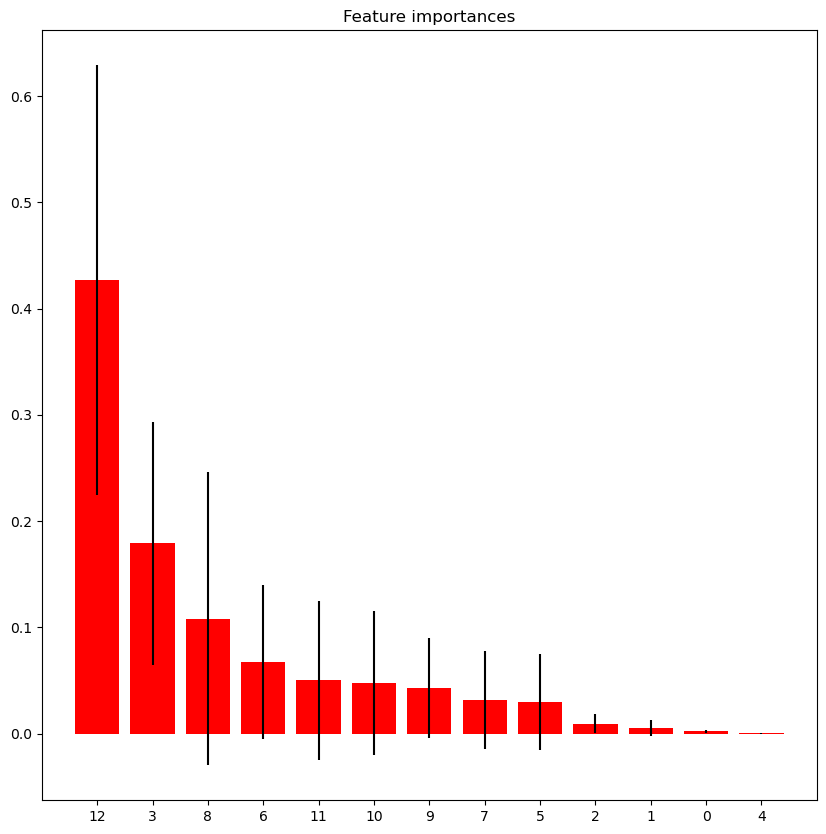

In [ ]:
# Write an algorithm to compute the most important features
importances = clf.named_estimators_['rf'].feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.named_estimators_['rf'].estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" %(f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices], color='r', yerr=std[indices], align='center')
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [ ]:
df_avg['PH']

0         7.678391
1         7.678391
2         7.678391
3         7.678391
4         7.678391
            ...   
311984    7.600000
311985    7.600000
311986    7.600000
311987    7.600000
311988    7.688261
Name: PH, Length: 311989, dtype: float64

In [ ]:
df_avg['EPI'].unique()

array([1, 3, 2, 5, 4, 6])

In [ ]:
# Write an algorithm to compute the features that correlate the most with a bad environment
df_avg['EPI'] = labeled_data['EPI']
df_avg
df_avg['EPI'] = df_avg['EPI'].replace('Excellent', 0)
df_avg['EPI'] = df_avg['EPI'].replace('Good', 1)
df_avg['EPI'] = df_avg['EPI'].replace('Satisfactory', 2)
df_avg['EPI'] = df_avg['EPI'].replace('Fair', 3)
df_avg['EPI'] = df_avg['EPI'].replace('Poor', 4)
df_avg['EPI'] = df_avg['EPI'].replace('Bad', 5)
df_avg['EPI'] = df_avg['EPI'].replace('Worse', 6)
df_avg['EPI'] = df_avg['EPI'].replace('Severe', 6)

df_avg.corr()['EPI'].sort_values(ascending=False)

EPI                                 1.000000
FECAL COLIFORM (MPN/100ml)          0.460490
spm                                 0.438515
B.O.D. (mg/l)                       0.412474
NITRATENAN N+ NITRITENANN (mg/l)    0.394033
TOTAL COLIFORM (MPN/100ml)Mean      0.377271
PH                                  0.344905
CONDUCTIVITY (mhos/cm)              0.219262
rspm                                0.211256
no2                                 0.084790
pm2_5                               0.044058
so2                                 0.033446
D.O. (mg/l)                        -0.268584
Name: EPI, dtype: float64

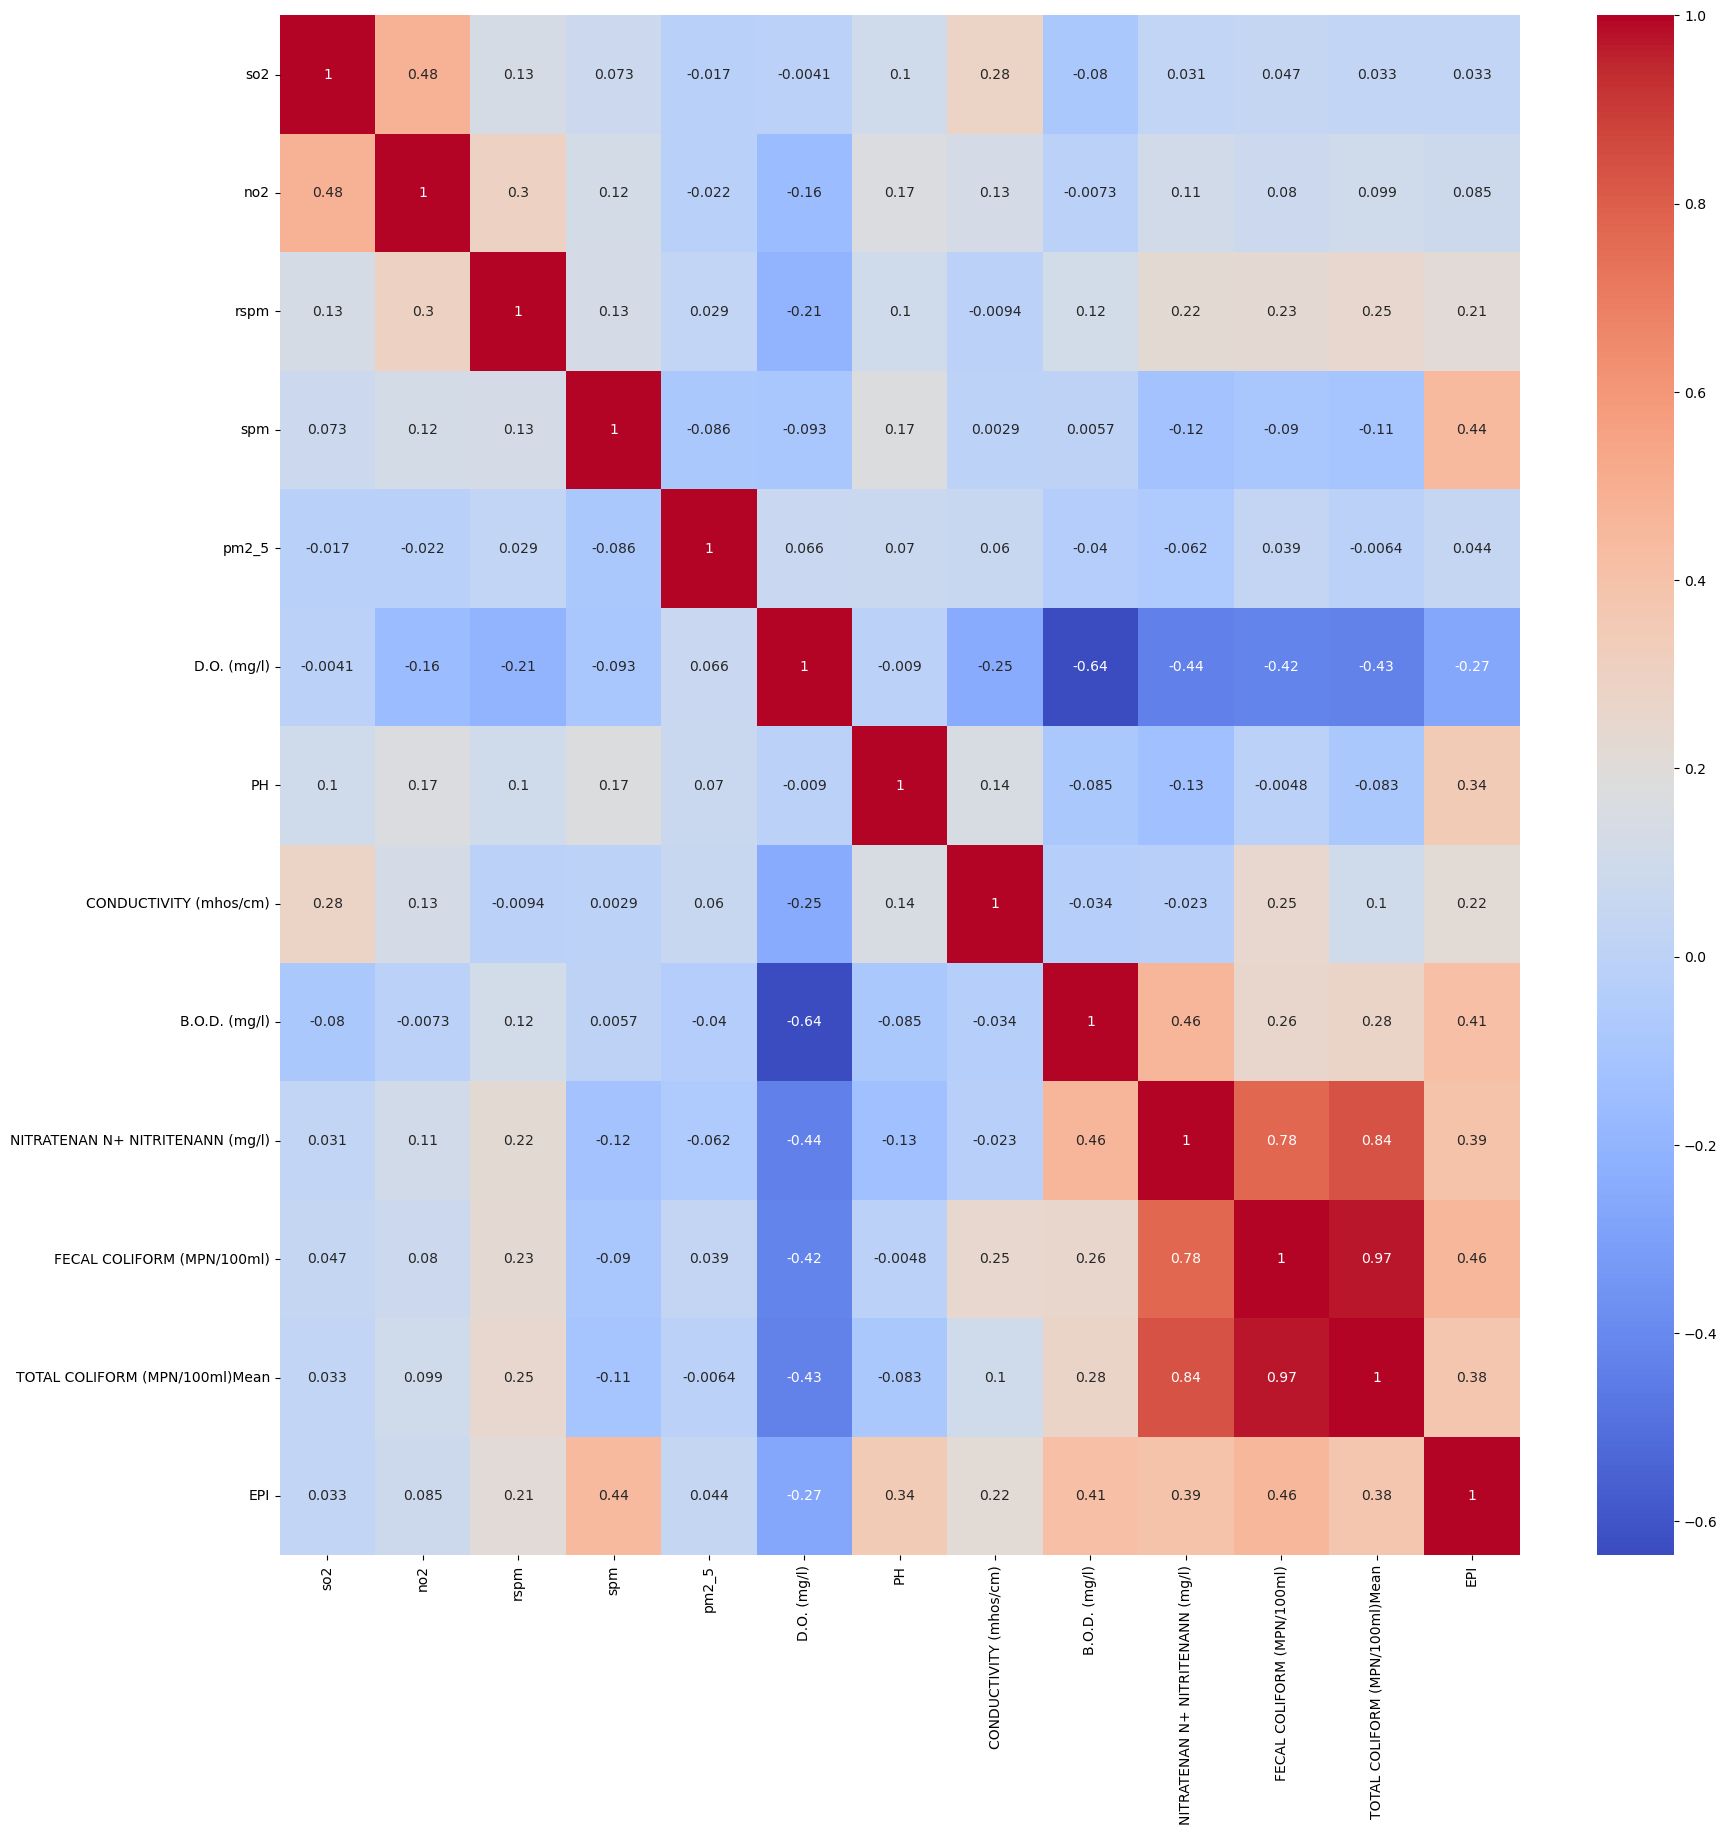

In [ ]:
# Make a plot of the correlation
import seaborn as sns
plt.figure(figsize=(20, 20))
sns.heatmap(df_avg.corr(), annot=True, cmap='coolwarm')
plt.show()